In [3]:
import sys
import subprocess

# Install matplotlib and seaborn in the current environment
subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib", "seaborn"])
print("✅ Installation complete!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 2.4 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 1.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.5/255.5 kB 2.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 1.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 1.2 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 849.9 kB/s eta 0:00:000:00:01
✅ Installation complete!



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip


In [4]:
import sqlite3
import pandas as pd
import numpy as np
import os
import re
from datetime import datetime
import glob
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options for better DataFrame viewing
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [5]:
class GroceryDatabase:
    def __init__(self, db_name="grocery_prices.db"):
        self.db_name = db_name
        self.conn = None
        self.setup_database()
    
    def setup_database(self):
        """Create database and tables"""
        print(f"🗄️ Setting up database: {self.db_name}")
        
        self.conn = sqlite3.connect(self.db_name)
        cursor = self.conn.cursor()
        
        # Create main products table
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS products (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                platform TEXT NOT NULL,
                name TEXT NOT NULL,
                price TEXT NOT NULL,
                price_numeric REAL,
                size TEXT,
                full_text TEXT,
                url TEXT,
                scrape_date TEXT,
                created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                UNIQUE(platform, name, price, scrape_date)
            )
        ''')
        
        # Create platform summary table
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS platform_summary (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                platform TEXT NOT NULL,
                product_count INTEGER,
                last_updated TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                UNIQUE(platform)
            )
        ''')
        
        # Create indexes for better performance
        cursor.execute('CREATE INDEX IF NOT EXISTS idx_platform ON products(platform)')
        cursor.execute('CREATE INDEX IF NOT EXISTS idx_name ON products(name)')
        cursor.execute('CREATE INDEX IF NOT EXISTS idx_price_numeric ON products(price_numeric)')
        
        self.conn.commit()
        print("✅ Database tables created successfully!")
    
    def extract_price_numeric(self, price_str):
        """Extract numeric price from price string"""
        if pd.isna(price_str):
            return None
        
        price_str = str(price_str)
        numbers = re.findall(r'[\d,]+\.?\d*', price_str)
        
        if numbers:
            price = numbers[0].replace(',', '')
            try:
                return float(price)
            except ValueError:
                return None
        return None
    
    def clean_product_data(self, df):
        """Clean and standardize product data"""
        df = df.copy()
        
        # Ensure required columns exist
        required_columns = ['platform', 'name', 'price']
        for col in required_columns:
            if col not in df.columns:
                print(f"⚠️ Missing required column: {col}")
                return None
        
        # Clean data
        df['name'] = df['name'].astype(str).str.strip()
        df['price'] = df['price'].astype(str).str.strip()
        df['platform'] = df['platform'].astype(str).str.strip()
        
        # Extract numeric price
        df['price_numeric'] = df['price'].apply(self.extract_price_numeric)
        
        # Add optional columns if they don't exist
        if 'size' not in df.columns:
            df['size'] = 'N/A'
        if 'full_text' not in df.columns:
            df['full_text'] = df['name']
        if 'url' not in df.columns:
            df['url'] = 'N/A'
        
        # Add scrape date
        df['scrape_date'] = datetime.now().strftime('%Y-%m-%d')
        
        # Remove rows with invalid data
        df = df.dropna(subset=['name', 'price'])
        df = df[df['name'] != '']
        df = df[df['price'] != '']
        
        return df
    
    def load_csv_to_database(self, csv_file):
        """Load a single CSV file into the database"""
        try:
            print(f"📄 Loading: {csv_file}")
            
            # Read CSV
            df = pd.read_csv(csv_file)
            print(f"   Raw data: {len(df)} rows")
            
            # Clean data
            df_clean = self.clean_product_data(df)
            if df_clean is None:
                print("   ❌ Failed to clean data")
                return False
            
            print(f"   Clean data: {len(df_clean)} rows")
            
            if len(df_clean) == 0:
                print("   ⚠️ No valid data to insert")
                return False
            
            # Insert data
            cursor = self.conn.cursor()
            inserted_count = 0
            
            for _, row in df_clean.iterrows():
                try:
                    cursor.execute('''
                        INSERT OR IGNORE INTO products 
                        (platform, name, price, price_numeric, size, full_text, url, scrape_date)
                        VALUES (?, ?, ?, ?, ?, ?, ?, ?)
                    ''', (row['platform'], row['name'], row['price'], row['price_numeric'], 
                          row['size'], row['full_text'], row['url'], row['scrape_date']))
                    
                    if cursor.rowcount > 0:
                        inserted_count += 1
                
                except Exception as e:
                    print(f"   Error inserting row: {e}")
                    continue
            
            self.conn.commit()
            print(f"   ✅ Inserted: {inserted_count} new products")
            return True
            
        except Exception as e:
            print(f"   ❌ Error loading {csv_file}: {e}")
            return False
    
    def get_all_products_df(self):
        """Get all products as DataFrame"""
        query = "SELECT * FROM products ORDER BY platform, name"
        return pd.read_sql_query(query, self.conn)
    
    def query_products(self, platform=None, search_term=None, min_price=None, max_price=None):
        """Query products with filters"""
        query = "SELECT * FROM products WHERE 1=1"
        params = []
        
        if platform:
            query += " AND platform = ?"
            params.append(platform)
        
        if search_term:
            query += " AND name LIKE ?"
            params.append(f"%{search_term}%")
        
        if min_price:
            query += " AND price_numeric >= ?"
            params.append(min_price)
        
        if max_price:
            query += " AND price_numeric <= ?"
            params.append(max_price)
        
        query += " ORDER BY platform, name"
        
        return pd.read_sql_query(query, self.conn, params=params)
    
    def get_platform_summary(self):
        """Get platform summary statistics"""
        query = '''
            SELECT platform, 
                   COUNT(*) as product_count,
                   MIN(price_numeric) as min_price, 
                   MAX(price_numeric) as max_price,
                   AVG(price_numeric) as avg_price,
                   COUNT(DISTINCT scrape_date) as scrape_sessions
            FROM products 
            WHERE price_numeric IS NOT NULL
            GROUP BY platform
            ORDER BY product_count DESC
        '''
        return pd.read_sql_query(query, self.conn)
    
    def close(self):
        """Close database connection"""
        if self.conn:
            self.conn.close()

# Initialize database
db = GroceryDatabase()
print("🎉 Database initialized and ready!")

🗄️ Setting up database: grocery_prices.db
✅ Database tables created successfully!
🎉 Database initialized and ready!


In [6]:
# Find all CSV files in current directory
csv_files = glob.glob("*.csv")

print(f"🔍 Found {len(csv_files)} CSV files:")
for file in csv_files:
    print(f"   - {file}")

# Load each CSV file
if csv_files:
    success_count = 0
    for csv_file in csv_files:
        if db.load_csv_to_database(csv_file):
            success_count += 1
    
    print(f"\n📊 Successfully loaded {success_count}/{len(csv_files)} files into database")
else:
    print("❌ No CSV files found!")

🔍 Found 5 CSV files:
   - zepto_milk_results.csv
   - zepto_ice_cream_results.csv
   - blinkit_tofu_results.csv
   - blinkit_milk_results.csv
   - blinkit_apple_results.csv
📄 Loading: zepto_milk_results.csv
   Raw data: 20 rows
   Clean data: 20 rows
   ✅ Inserted: 19 new products
📄 Loading: zepto_ice_cream_results.csv
   Raw data: 25 rows
   Clean data: 25 rows
   ✅ Inserted: 24 new products
📄 Loading: blinkit_tofu_results.csv
   Raw data: 4 rows
   Clean data: 4 rows
   ✅ Inserted: 4 new products
📄 Loading: blinkit_milk_results.csv
   Raw data: 20 rows
   Clean data: 20 rows
   ✅ Inserted: 20 new products
📄 Loading: blinkit_apple_results.csv
   Raw data: 15 rows
   Clean data: 15 rows
   ✅ Inserted: 15 new products

📊 Successfully loaded 5/5 files into database


In [7]:
# Get platform summary
summary_df = db.get_platform_summary()

print("📊 PLATFORM SUMMARY")
print("=" * 60)
display(summary_df)

# Total products
total_products = summary_df['product_count'].sum()
print(f"\n🎯 Total products in database: {total_products}")

# Price range across all platforms
all_products = db.get_all_products_df()
if not all_products.empty and 'price_numeric' in all_products.columns:
    valid_prices = all_products[all_products['price_numeric'].notna()]
    if not valid_prices.empty:
        print(f"💰 Overall price range: ₹{valid_prices['price_numeric'].min():.0f} - ₹{valid_prices['price_numeric'].max():.0f}")

📊 PLATFORM SUMMARY


,platform,product_count,min_price,max_price,avg_price,scrape_sessions
0,Zepto,43,16.0,610.0,111.279070,1
1,Blinkit,39,16.0,1169.0,150.871795,1



🎯 Total products in database: 82
💰 Overall price range: ₹16 - ₹1169


In [8]:
# Display all products in a nice format
all_products = db.get_all_products_df()

if not all_products.empty:
    print(f"📋 ALL PRODUCTS ({len(all_products)} total)")
    print("=" * 80)
    
    # Show key columns
    display_columns = ['platform', 'name', 'price', 'size', 'scrape_date']
    available_columns = [col for col in display_columns if col in all_products.columns]
    
    display(all_products[available_columns])
else:
    print("❌ No products in database")

📋 ALL PRODUCTS (82 total)


,platform,name,price,size,scrape_date
0,Blinkit,Amul Gold Full Cream Fresh Milk + Baby Banana ...,₹69,N/A,2025-06-14
1,Blinkit,Amul Gold Full Cream Fresh Milk + Banana Robus...,₹83,N/A,2025-06-14
2,Blinkit,Amul Gold Full Cream Milk,₹35,N/A,2025-06-14
3,Blinkit,Amul Gold Milk,₹80,N/A,2025-06-14
4,Blinkit,Amul Kool Cafe Milk 'n' Coffee Flavoured Milk,₹30,N/A,2025-06-14
...,...,...,...,...,...
77,Zepto,Vadilal Almond Crunch Badabite Ice Cream Stick,₹50,N/A,2025-06-14
78,Zepto,Vadilal Silk Gourmet Ice Cream Cup,₹50,N/A,2025-06-14
79,Zepto,Verka Full Cream Fresh Milk,₹69,N/A,2025-06-14
80,Zepto,Verka Standard Fresh Milk,₹32,N/A,2025-06-14


In [9]:
# Search for specific products
search_term = "milk"  # Change this to search for different products

print(f"🔍 Searching for products containing '{search_term}':")
search_results = db.query_products(search_term=search_term)

if not search_results.empty:
    display_columns = ['platform', 'name', 'price', 'price_numeric']
    available_columns = [col for col in display_columns if col in search_results.columns]
    display(search_results[available_columns])
else:
    print(f"❌ No products found containing '{search_term}'")

🔍 Searching for products containing 'milk':


,platform,name,price,price_numeric
0,Blinkit,Amul Gold Full Cream Fresh Milk + Baby Banana ...,₹69,69.0
1,Blinkit,Amul Gold Full Cream Fresh Milk + Banana Robus...,₹83,83.0
2,Blinkit,Amul Gold Full Cream Milk,₹35,35.0
3,Blinkit,Amul Gold Milk,₹80,80.0
4,Blinkit,Amul Kool Cafe Milk 'n' Coffee Flavoured Milk,₹30,30.0
5,Blinkit,Amul Kool Elaichi Flavoured Milk,₹25,25.0
6,Blinkit,Amul Kool Kesar Flavoured Milk,₹25,25.0
7,Blinkit,Amul Lactose Free Milk,₹25,25.0
8,Blinkit,Amul Moti Toned Milk (90 Days Shelf Life),₹33,33.0
9,Blinkit,Amul Pure Milk Cheese Slices,₹145,145.0


📊 PLATFORM COMPARISON FOR 'MILK'


price_numeric                      name
                 count   min    max   mean count
platform                                        
Blinkit             18  16.0  145.0  57.00    18
Zepto               14  16.0   69.0  40.57    14

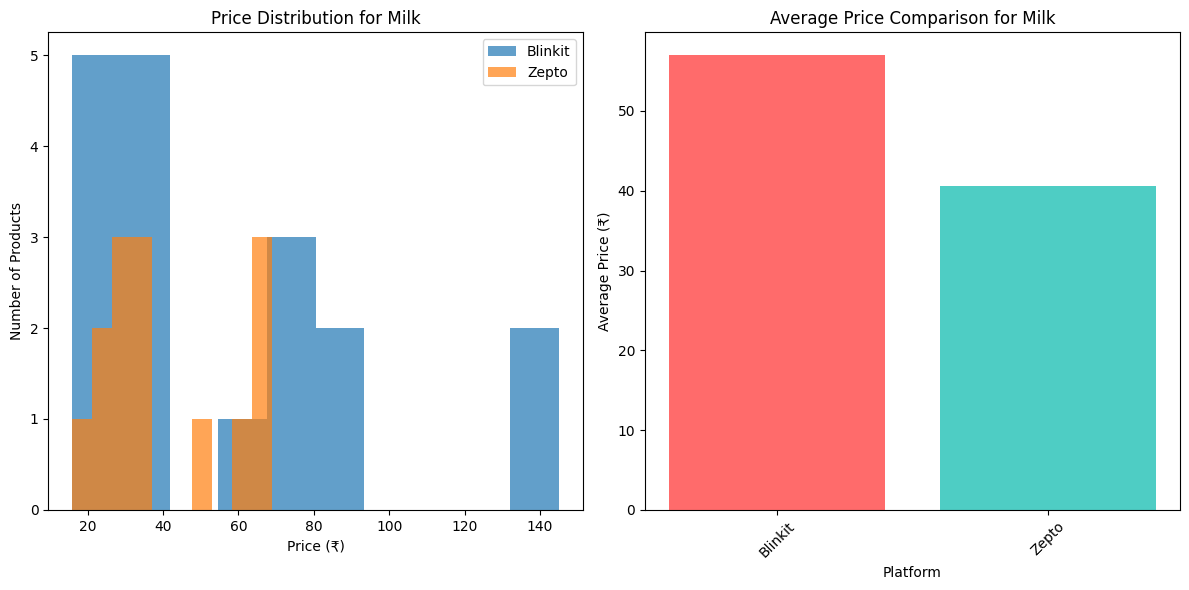

In [10]:
# Compare products across platforms
search_term = "milk"  # Product to compare
comparison_results = db.query_products(search_term=search_term)

if not comparison_results.empty:
    print(f"📊 PLATFORM COMPARISON FOR '{search_term.upper()}'")
    print("=" * 60)
    
    # Group by platform
    platform_stats = comparison_results.groupby('platform').agg({
        'price_numeric': ['count', 'min', 'max', 'mean'],
        'name': 'count'
    }).round(2)
    
    display(platform_stats)
    
    # Show price distribution
    if len(comparison_results) > 0:
        plt.figure(figsize=(12, 6))
        
        # Plot 1: Price distribution by platform
        plt.subplot(1, 2, 1)
        for platform in comparison_results['platform'].unique():
            platform_data = comparison_results[comparison_results['platform'] == platform]
            plt.hist(platform_data['price_numeric'], alpha=0.7, label=platform, bins=10)
        
        plt.xlabel('Price (₹)')
        plt.ylabel('Number of Products')
        plt.title(f'Price Distribution for {search_term.title()}')
        plt.legend()
        
        # Plot 2: Average price by platform
        plt.subplot(1, 2, 2)
        avg_prices = comparison_results.groupby('platform')['price_numeric'].mean()
        plt.bar(avg_prices.index, avg_prices.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
        plt.xlabel('Platform')
        plt.ylabel('Average Price (₹)')
        plt.title(f'Average Price Comparison for {search_term.title()}')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()

In [11]:
# Find products available on multiple platforms and show best deals
all_products = db.get_all_products_df()

if not all_products.empty:
    print("💰 FINDING BEST DEALS ACROSS PLATFORMS")
    print("=" * 60)
    
    # Normalize product names for better matching
    all_products['normalized_name'] = all_products['name'].str.lower().str.replace(r'[^\w\s]', '', regex=True)
    
    # Find products available on multiple platforms
    product_counts = all_products['normalized_name'].value_counts()
    common_products = product_counts[product_counts >= 2].index.tolist()
    
    print(f"Found {len(common_products)} products available on multiple platforms")
    
    if common_products:
        deals = []
        
        for product in common_products[:10]:  # Top 10 for display
            product_data = all_products[all_products['normalized_name'] == product]
            
            if len(product_data) >= 2:
                platforms = product_data['platform'].tolist()
                prices = product_data['price_numeric'].tolist()
                names = product_data['name'].tolist()
                
                # Filter out None prices
                valid_data = [(p, pr, n) for p, pr, n in zip(platforms, prices, names) if pr is not None]
                
                if len(valid_data) >= 2:
                    platforms, prices, names = zip(*valid_data)
                    
                    min_price = min(prices)
                    max_price = max(prices)
                    savings = max_price - min_price
                    savings_percent = (savings / max_price) * 100 if max_price > 0 else 0
                    
                    best_platform = platforms[prices.index(min_price)]
                    worst_platform = platforms[prices.index(max_price)]
                    
                    deals.append({
                        'Product': names[0],
                        'Platforms': ', '.join(platforms),
                        'Min Price': f"₹{min_price:.0f}",
                        'Max Price': f"₹{max_price:.0f}",
                        'Savings': f"₹{savings:.0f}",
                        'Savings %': f"{savings_percent:.1f}%",
                        'Best Platform': best_platform,
                        'Worst Platform': worst_platform
                    })
        
        if deals:
            deals_df = pd.DataFrame(deals)
            deals_df = deals_df.sort_values('Savings %', ascending=False)
            display(deals_df)
        else:
            print("No comparable products found")

💰 FINDING BEST DEALS ACROSS PLATFORMS
Found 5 products available on multiple platforms


,Product,Platforms,Min Price,Max Price,Savings,Savings %,Best Platform,Worst Platform
2,Farmley Apple Pie Date Bites,"Blinkit, Blinkit",₹34,₹348,₹314,90.2%,Blinkit,Blinkit
3,Amul Gold Full Cream Fresh Milk (Pouch),"Zepto, Zepto",₹35,₹69,₹34,49.3%,Zepto,Zepto
0,Verka Standard Fresh Milk,"Blinkit, Zepto, Zepto",₹32,₹63,₹31,49.2%,Zepto,Blinkit
1,Amul Gold TriCone Butterscotch Ice Cream Cone ...,"Zepto, Zepto",₹60,₹87,₹27,31.0%,Zepto,Zepto
4,Amul Kool Badam Pet 180 ml Combo,"Zepto, Zepto",₹100,₹125,₹25,20.0%,Zepto,Zepto


In [12]:
# Export database to CSV
export_filename = f"grocery_database_export_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"

all_products = db.get_all_products_df()
if not all_products.empty:
    all_products.to_csv(export_filename, index=False)
    print(f"📤 Database exported to: {export_filename}")
    print(f"📊 Exported {len(all_products)} products")
else:
    print("❌ No data to export")

📤 Database exported to: grocery_database_export_20250614_1441.csv
📊 Exported 82 products


In [13]:
# Close database connection
db.close()
print("🔒 Database connection closed")
print("✅ All operations completed successfully!")

🔒 Database connection closed
✅ All operations completed successfully!
